In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import torch.nn.functional as F

# Load the bounding box data
df = pd.read_csv('norm_bounding_boxes.csv')

# Define a custom dataset class
class FaceDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        bbox = self.dataframe.iloc[idx, 1:5].values
        cropped = image.crop((bbox[0], bbox[1], bbox[2], bbox[3]))
        
        if self.transform:
            cropped = self.transform(image)
        
        return image, cropped  # Input image and target are the same for autoencoders

# Transformations
transform = transforms.Compose([
    transforms.Resize((208, 176)),
    # transforms.Resize((208, 176)),
    transforms.ToTensor()
])

# Initialize dataset and dataloader
dataset = FaceDataset(df, 'celeba_imgs', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [16]:
dataset[1][0].shape

torch.Size([3, 208, 176])

In [42]:

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            # nn.Conv2d(3, 8, 3, 1, 1),  # Output: (8, H/2, W/2)
            # nn.ReLU(True),
            nn.Conv2d(3, 16, 3, 1, 1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 48, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(48, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(64, 96, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(96, 96, 4, 2, 1),
            nn.ReLU(True),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(96, 96, 4, 2, 1, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(96, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 48, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(48, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, 1, 1),
            # nn.ReLU(True),
            # nn.ConvTranspose2d(8, 3, 3, 1, 1),
            nn.Sigmoid()
        )
        # latent_dim = 1000
        # self.encoder = nn.Sequential(
        #     nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Maintains 218x178
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2),  # Reduces to 109x89
        #     nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # Maintains 109x89
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2),  # Reduces to 54x44
        #     nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Maintains 54x44
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2),  # Reduces to 27x22
        #     nn.Flatten(),
        #     nn.Linear(64 * 27 * 22, latent_dim),
        #     nn.ReLU()
        # )
        # # Decoder
        # self.decoder = nn.Sequential(
        #     nn.Linear(latent_dim, 64 * 27 * 22),
        #     nn.ReLU(),
        #     nn.Unflatten(1, (64, 27, 22)),
        #     nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Outputs 54x44
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Outputs 109x89
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=0),  # Outputs 218x178
        #     nn.Sigmoid()  # Ensures output values are between 0 and 1
        # )

        
    def forward(self, x):
        encoded = self.encoder(x)
        print(encoded.shape)
        decoded = self.decoder(encoded)
        return decoded
# Initialize model, loss function, and optimizer
model2 = Autoencoder()
criterion = nn.L1Loss()
optimizer = optim.Adam(model2.parameters(), lr=0.01)

Training Progress:   0%|          | 0/307 [00:00<?, ?it/s]

Iteration 1, Loss: 0.0621 -- 0.0621 -- 1.0000


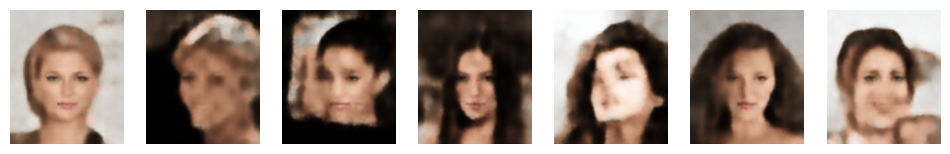

Training Progress:  16%|█▋        | 50/307 [00:05<00:29,  8.80it/s]

Iteration 51, Loss: 0.0742 -- 0.0742 -- 1.0000


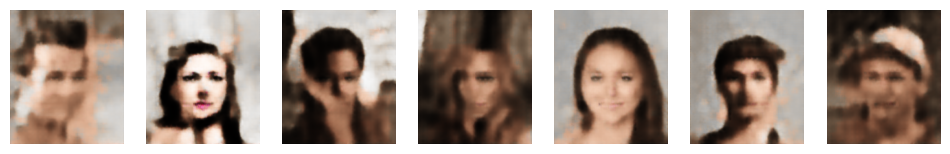

Training Progress:  33%|███▎      | 100/307 [00:11<00:22,  9.19it/s]

Iteration 101, Loss: 0.0701 -- 0.0701 -- 1.0000


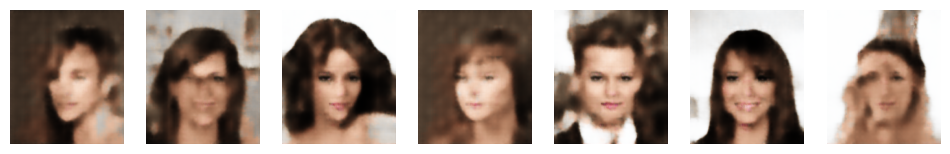

Training Progress:  38%|███▊      | 116/307 [00:14<00:23,  8.27it/s]


KeyboardInterrupt: 

In [44]:
from tqdm import tqdm

# Training loop
for i, data in enumerate(tqdm(dataloader, desc="Training Progress")):
    img, target = data
    # Forward pass
    output = model3(img)

    l1 = criterion(target, output)
    # cos = cosine_loss(target, output)
    cos = 1
    # loss = l1 + cos
    loss = l1 
    # loss = nn.MSELoss()(target, output)
    # loss = cosine_loss(target, output)

    # Backward pass and optimize
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()

    # Report loss every 25 iterations
    if i % 50 == 0:
        print(f'Iteration {i+1}, Loss: {loss.item():.4f} -- {l1:.4f} -- {cos:.4f}')
        plot_tensor(output[:7].detach())

Training Progress:   0%|          | 0/307 [00:00<?, ?it/s]

torch.Size([16, 96, 6, 5])
Iteration 1, Loss: 0.2630 -- 0.2630 -- 1.0000


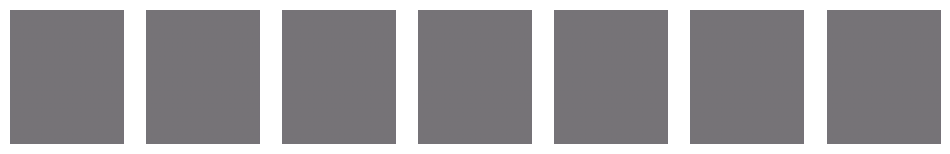

Training Progress:   0%|          | 1/307 [00:00<02:14,  2.27it/s]

torch.Size([16, 96, 6, 5])


Training Progress:   1%|          | 3/307 [00:01<01:35,  3.17it/s]

torch.Size([16, 96, 6, 5])
torch.Size([16, 96, 6, 5])


Training Progress:   1%|▏         | 4/307 [00:01<01:33,  3.25it/s]

torch.Size([16, 96, 6, 5])


Training Progress:   2%|▏         | 5/307 [00:01<01:45,  2.87it/s]

torch.Size([16, 96, 6, 5])


Training Progress:   2%|▏         | 6/307 [00:02<01:58,  2.54it/s]

torch.Size([16, 96, 6, 5])


KeyboardInterrupt: 

In [43]:
from tqdm import tqdm

# Training loop
for i, data in enumerate(tqdm(dataloader, desc="Training Progress")):
    img, target = data
    # Forward pass
    output = model3(img)

    l1 = criterion(target, output)
    # cos = cosine_loss(target, output)
    cos = 1
    # loss = l1 + cos
    loss = l1 
    # loss = nn.MSELoss()(target, output)
    # loss = cosine_loss(target, output)

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Report loss every 25 iterations
    if i % 50 == 0:
        print(f'Iteration {i+1}, Loss: {loss.item():.4f} -- {l1:.4f} -- {cos:.4f}')
        plot_tensor(output[:7].detach())

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_tensor(tensor):
    """
    Plots images from a 4D tensor (batch, C, W, H) with 3 color channels.
    
    Args:
    tensor (numpy.ndarray): The 4D tensor to plot, with shape (batch, C, W, H).
    """
    if tensor.shape[1] != 3:
        raise ValueError("Tensor must have 3 channels")

    batch_size = tensor.shape[0]
    rows = (batch_size + 6) // 7  # Calculate the number of rows needed

    fig, axes = plt.subplots(rows, 7, figsize=(12, 2 * rows))
    # fig.tight_layout(pad=0.1)

    # Flattening the axes array for easy iteration
    axes = axes.ravel()

    for i in range(batch_size):
        # Transpose tensor to shape (W, H, C) for plotting
        img = tensor[i].permute(1, 2, 0)
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis
    
    # Turn off axes for any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.show()